In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from src.encoders_decoders import *
from src.losses import *




PART 1: REPRODUCING WOODFORD'S RESULTS
Given a gaussian decoder, the ideal optimal encoder is computed as the functional derivative of the loss and used in the computation of the latter, which will now uniquely depend on the decoder.
Results similar to Woodford's ones are recovered making use of Stochastic Gradient Descent instead of Expectation-Maximization algorithm

In [2]:
N = 20
mu0 = torch.arange(0,10,10/N)[None,:]
sigma0 = torch.ones(N)[None,:]
q0 = 1/N*torch.ones(N)[None,:]

#Define data distribution: exponential distribution 
x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
#x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item() 

#Definition of the encoder and the decoder: the first section will only make use of the decoder
decoder=GaussianDecoder_orig(mu0,sigma0,q0)
encoder=CategoricalEncoder(mu0,sigma0,q0)

#Define optimizer and parameters to iterate on
params = decoder.parameters()
optimizer = torch.optim.SGD(params,lr=0.01,momentum=0.9)
loss = simplified_loss_orig(x_data,decoder)

c:\Users\auror\VAEs\src\encoders_decoders.py:162: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.q  = torch.nn.Parameter(F.softmax(q0))


In [3]:
#training 
loss_class = []

for i in range(1,4000):
    running_loss_tot=0
   
    loss = simplified_loss_orig(x_data, decoder)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss_tot = loss.item()
    loss_class.append(running_loss_tot)

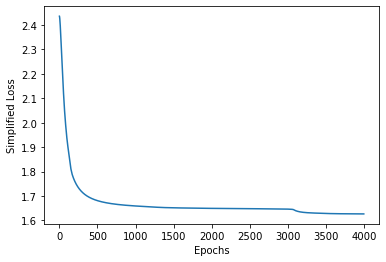

In [4]:
plt.xlabel("Epochs")
plt.ylabel("Simplified Loss")
plt.plot(loss_class)

<ipython-input-5-a8b518301830>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,:]))


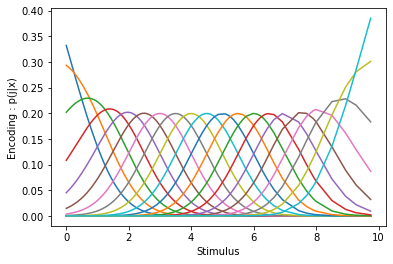

In [5]:
#Reproducing Woodford's plots: ENCODING

with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding : p(j|x)")
    plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,:])) 

c:\Users\auror\VAEs\src\encoders_decoders.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.q  = torch.nn.Parameter(F.softmax(q0))


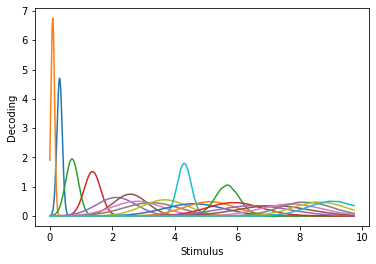

In [6]:
#DECODING

res = GaussianDecoder_orig(mu0,sigma0,q0)
mu_dec, sigma_dec = res(x_sorted)
gaussian = torch.distributions.normal.Normal(mu_dec, sigma_dec)
gauss_logprob = (gaussian.log_prob(x_sorted.transpose(0,1))).transpose(0,1)

with torch.no_grad():
    plt.plot(x_sorted, torch.exp(gauss_logprob[:,:]))
    plt.xlabel("Stimulus")
    plt.ylabel("Decoding")

PART 2: LOSS AND MSE EVALUATION WITHOUT THE OPTIMAL ENCODER
The encoder parameters are learned


In [7]:
N = 20
mu0 = torch.arange(0,10,10/N)[None,:]
sigma0 = torch.ones(N)[None,:]
q0 = 1/N*torch.ones(N)[None,:]

#Define data distribution
x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item() 

encoder = CategoricalEncoder(mu0,sigma0,q0)
decoder = GaussianDecoder_orig(mu0,sigma0,q0)

#Define optimizer and parameters to iterate on
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.SGD(params,lr=0.001,momentum=0.9)
loss = distortion_cat_orig(x_data, encoder, decoder) + rate_cat_orig(x_data, encoder, decoder)

c:\Users\auror\VAEs\src\encoders_decoders.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.q  = torch.nn.Parameter(F.softmax(q0))
c:\Users\auror\VAEs\src\losses.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = -((F.softmax(p_j_x))*logq_x_j).sum(dim=1).mean()
c:\Users\auror\VAEs\src\losses.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = ((F.softmax(p_j_x))*(F.log_softmax(p_j_x) - F.log_softmax(decoder.q))).sum(dim=1).mean()
c:\Users\auror\VAEs\src\losses.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = ((F.softmax(p_j_x))*(F.log_softmax(p_j_x) - F.log_softmax(decoder.q))).sum(dim=1).mean()


In [8]:
#Training
loss_class = []
mse_val = []

for i in range(1,4000):
    running_loss_tot=0
    running_mse=0
   
    loss = distortion_cat_orig(x_data, encoder, decoder) + rate_cat_orig(x_data, encoder, decoder)
    mse=MSE_cat_orig(x_data, encoder, decoder)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    running_loss_tot = loss.item()
    running_mse = mse.item()

    
    loss_class.append(running_loss_tot)
    mse_val.append(running_mse)

c:\Users\auror\VAEs\src\losses.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mse = ((F.softmax(p_j_x))*(x**2 + decoder.mu.transpose(0,1)**2 -2*x*decoder.mu.transpose(0,1) + decoder.sigma.transpose(0,1)**2)).sum(dim=1).mean()


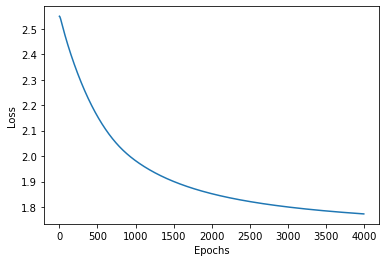

In [9]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_class) 

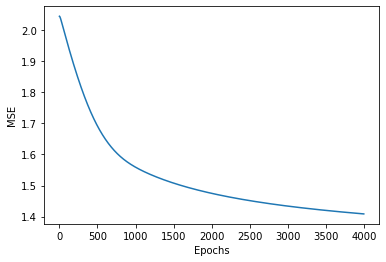

In [10]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(mse_val)

<ipython-input-11-e5462b003293>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,6]))


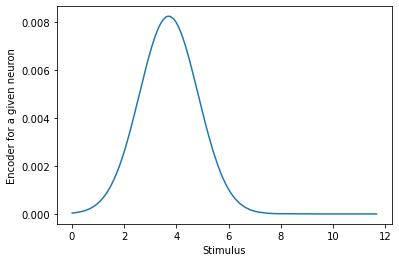

In [11]:
#ENCODING

with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoder for a given neuron")
    plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,6]))  

<ipython-input-12-c44b9b4cd19c>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,:]))


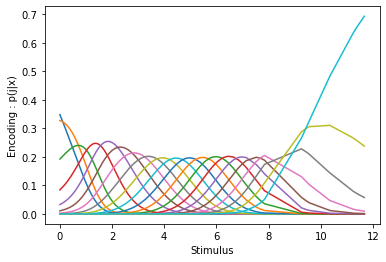

In [12]:
with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding : p(j|x)")
    plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,:])) 

c:\Users\auror\VAEs\src\encoders_decoders.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.q  = torch.nn.Parameter(F.softmax(q0))


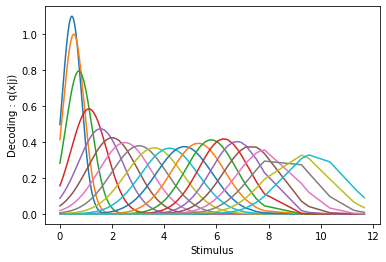

In [13]:
#DECODING      
res = GaussianDecoder_orig(mu0,sigma0,q0)
#res=MoGDecoder(N,x_min,x_max)
mu_dec, sigma_dec = res(x_sorted)
gaussian = torch.distributions.normal.Normal(mu_dec, sigma_dec)
a = (gaussian.log_prob(x_sorted.transpose(0,1))).transpose(0,1)

with torch.no_grad():
    plt.plot(x_sorted, torch.exp(a[:,:]))
    plt.xlabel("Stimulus")
    plt.ylabel("Decoding : q(x|j)")



How does the MSE varies when minimizing (Reconstruction + Dkl) or (MSE + Dkl) ?

In [14]:
loss_mse = []
mse_val1 = []

for i in range(1,4000):
    running_loss_tot=0
    running_mse_val1=0
    
    
    loss = MSE_cat_orig(x_data, encoder, decoder) + rate_cat_orig(x_data, encoder, decoder)
    mse1=MSE_cat_orig(x_data, encoder, decoder)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    running_loss_tot = loss.item()
    running_mse_val1=mse1.item()
    loss_mse.append(running_loss_tot)
    mse_val1.append(running_mse_val1)

c:\Users\auror\VAEs\src\losses.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mse = ((F.softmax(p_j_x))*(x**2 + decoder.mu.transpose(0,1)**2 -2*x*decoder.mu.transpose(0,1) + decoder.sigma.transpose(0,1)**2)).sum(dim=1).mean()
c:\Users\auror\VAEs\src\losses.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = ((F.softmax(p_j_x))*(F.log_softmax(p_j_x) - F.log_softmax(decoder.q))).sum(dim=1).mean()
c:\Users\auror\VAEs\src\losses.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = ((F.softmax(p_j_x))*(F.log_softmax(p_j_x) - F.log_softmax(decoder.q))).sum(dim=1).mean()


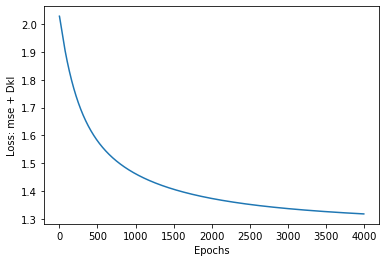

In [15]:
plt.xlabel("Epochs")
plt.ylabel("Loss: mse + Dkl")
plt.plot(loss_mse) 

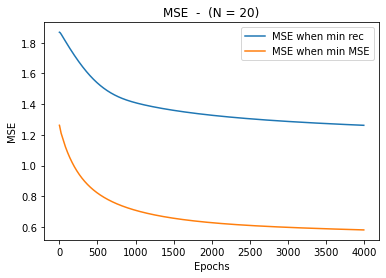

In [16]:
plt.plot(mse_val, label = "MSE when minimizing Rec + DKL")
plt.plot(mse_val1, label = "MSE when minimizing MSE + DKL")
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE  -  (N = 20)')
plt.legend()

plt.show()

LOSS BEHAVIOUR FOR DIFFERENT N VALUES
Mixture of Gaussians decoder introduced


In [22]:
x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)

#TRAINING FUNCTION 

def training(N):
    #parameters initialization
    mu0 = torch.arange(0,10,10/N)[None,:]
    sigma0 = torch.ones(N)[None,:]
    q0 = 1/N*torch.ones(N)[None,:]
    
    #model and parameters

    decoder=MoGDecoder(N,x_min,x_max)
    encoder=CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))
   
    params = list(decoder.parameters()) + list(encoder.parameters())
    optimizer = torch.optim.SGD(params,lr=0.01,momentum=0.9)
    loss = distortion_cat(x_data, encoder, decoder) + rate_cat(x_data, encoder, decoder)
    
    #training
    loss_val = []
    mse_val = []
    for i in range(1,5000):
        running_loss=0
        running_mse=0
   
        loss = distortion_cat(x_data, encoder, decoder) + rate_cat(x_data, encoder, decoder)
        mse=MSE_cat(x_data, decoder, encoder)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        running_loss = loss.item()
        running_mse = mse.item()

    
        loss_val.append(running_loss)
        mse_val.append(running_mse)
        
    
    return loss_val, mse_val

In [26]:
Nvec = np.arange(10,65,5)
for i in Nvec:
    loss, mse = training(i)





In [23]:
loss_10 , mse_10 = training(10)
loss_15 , mse_15 = training(15)
loss_20 , mse_20 = training(20)
loss_25 , mse_25 = training(25)
loss_30 , mse_30 = training(30)
loss_35 , mse_35 = training(35)
loss_40 , mse_40 = training(40)
loss_45 , mse_45 = training(45)
loss_50 , mse_50 = training(50)
loss_55 , mse_55 = training(55)
loss_60 , mse_60 = training(60)


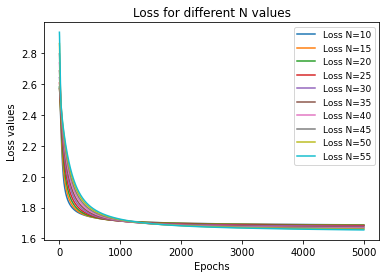

In [24]:
plt.plot(loss_10, label = "Loss N=10")
plt.plot(loss_15, label = "Loss N=15")
plt.plot(loss_20, label = "Loss N=20")
plt.plot(loss_25, label = "Loss N=25")
plt.plot(loss_30, label = "Loss N=30")
plt.plot(loss_35, label = "Loss N=35")
plt.plot(loss_40, label = "Loss N=40")
plt.plot(loss_45, label = "Loss N=45")
plt.plot(loss_50, label = "Loss N=50")
plt.plot(loss_55, label = "Loss N=55")

plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title( 'Loss for different N values')
plt.legend(loc = "upper right", prop={'size': 9})

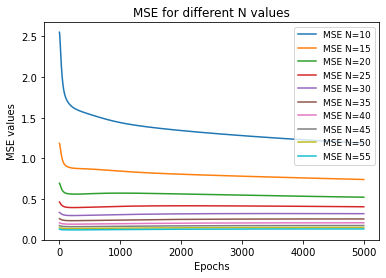

In [25]:
plt.plot(mse_10, label = "MSE N=10")
plt.plot(mse_15, label = "MSE N=15")
plt.plot(mse_20, label = "MSE N=20")
plt.plot(mse_25, label = "MSE N=25")
plt.plot(mse_30, label = "MSE N=30")
plt.plot(mse_35, label = "MSE N=35")
plt.plot(mse_40, label = "MSE N=40")
plt.plot(mse_45, label = "MSE N=45")
plt.plot(mse_50, label = "MSE N=50")
plt.plot(mse_55, label = "MSE N=55")

plt.xlabel('Epochs')
plt.ylabel('MSE values')
plt.title('MSE for different N values')
plt.legend(loc = "upper right", prop={'size': 9})

plt.show()